In [18]:
from typing import Annotated
from typing_extensions import TypedDict
from datetime import datetime
from dateutil.parser import parse
import json

from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from langchain.tools import StructuredTool
from langchain_core.messages import ToolMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [19]:
# 讀取環境變數(設定OPENAI_API_KEY)
load_dotenv()

True

In [20]:
# 工具 1: 取得目前時間
def get_current_time() -> str:
    """取得目前時間（無需輸入參數）"""
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# 工具 2: 計算時間差
def calculate_time_difference(start_time: str, end_time: str) -> str:
    """
    計算兩個時間之間已過或剩餘多久。
    start_time: 開始時間，格式為 'YYYY-MM-DD HH:MM:SS'
    end_time: 結束時間，格式為 'YYYY-MM-DD HH:MM:SS'
    """
    try:
        start = parse(start_time)
        end = parse(end_time)
        if start >= end:
            delta = start - end
            prefix = "已過"
        else:
            delta = end - start
            prefix = "還有"
        days = delta.days
        hours = delta.seconds // 3600
        minutes = (delta.seconds % 3600) // 60
        return f"{prefix} {days} 天 {hours} 小時 {minutes} 分鐘"
    except Exception as e:
        return f"錯誤: {e}"

# 將工具包裝成 LangChain Tool
get_current_time_tool = StructuredTool.from_function(get_current_time)
time_diff_tool = StructuredTool.from_function(calculate_time_difference)
tools = [get_current_time_tool, time_diff_tool]

In [21]:
# 定義狀態結構
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 建立 Graph
graph_builder = StateGraph(State)

# 建立 LLM (支援工具呼叫)
llm = init_chat_model("openai:gpt-4o")
llm_with_tools = llm.bind_tools(tools)

# 建立LLM 節點：負責回應或呼叫工具
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
graph_builder.add_node("chatbot", chatbot)

# 工具節點：執行 AIMessage 中請求的工具
class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("沒有可處理的訊息")

        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content = json.dumps(tool_result, ensure_ascii=False),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# 工具路由邏輯：決定是否需要進入工具節點
def route_tools(state: State):
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"無法找到可用的訊息: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

# 建立圖形流程(Agent Loop)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",     # 當前節點名稱: 代表 AI 回覆後，我們要決定下一步
    route_tools,   # 條件判斷函數: 負責檢查 AI 回覆裡有沒有工具呼叫
    {"tools": "tools", END: END},  # 條件映射: 定義可能的結果
)
graph_builder.add_edge("tools", "chatbot")
graph = graph_builder.compile()

In [23]:
# 執行聊天機器人
def stream_graph_updates(user_input: str):
    print("User:", user_input)
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            for msg in value["messages"]:
                if msg.type == "ai":
                    # AI 回覆，顯示給使用者
                    print("Assistant:", msg.content)
                elif msg.type == "tool":
                    # 工具回覆
                    print(f"[Assistant使用Tool: {msg.name}] → {msg.content}")
            
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: 請問現在時間幾點?
Assistant: 
[Assistant使用Tool: get_current_time] → "2025-09-28 11:10:39"
Assistant: 現在的時間是 2025年9月28日 11:10:39。
User: 請問現在時間離2025/12/31還有多久?
Assistant: 
[Assistant使用Tool: get_current_time] → "2025-09-28 11:10:48"
[Assistant使用Tool: get_current_time] → "2025-09-28 11:10:48"
Assistant: 
[Assistant使用Tool: calculate_time_difference] → "還有 93 天 12 小時 49 分鐘"
Assistant: 現在時間距離2025年12月31日還有93天12小時49分鐘。
Goodbye!


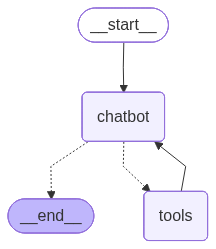

In [6]:
# 視覺化
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass